# Get Territory raw data data from google cloud storage

In [114]:
from google.cloud import storage
import json

In [115]:
# Instantiate a Google Cloud Storage client and specify required bucket and file
storage_client = storage.Client()
bucket = storage_client.get_bucket('opengeokpi-bucket')

In [116]:
# get blobs
blob_zones = bucket.blob('raw/territory/geozones-france-2019.json')

In [117]:
# Download the contents of the blob as a string and then parse it using json.loads() method
data_zones = json.loads(blob_zones.download_as_string(client=None))

# Prepare data
## Regions

In [118]:
import geopandas as gpd
from shapely import wkt

In [119]:
# convert geojson to geopandadataframe
gdf_zones = gpd.GeoDataFrame.from_features(data_zones["features"])

In [120]:
# set crs
gdf_zones = gdf_zones.set_crs(epsg=4326)

In [121]:
# select regions
gdf_zones_regions =  gdf_zones[gdf_zones.level == 'fr:region']

In [122]:
# subset columns
gdf_zones_regions = gdf_zones_regions[['geometry','level','code','name','population','area']]

In [123]:
# rename columns
gdf_zones_regions = gdf_zones_regions.rename(columns={
                                  "level": "regions_level",
                                 "code": "regions_code",
                                  "name":"regions_name",
                                 "population":"regions_population",
                                 "area":"regions_area"})

In [124]:
# check null values
null_columns=gdf_zones_regions.columns[gdf_zones_regions.isnull().any()]
gdf_zones_regions[null_columns].isnull().sum()

Series([], dtype: float64)

In [125]:
# save region geojson
with open('data/territory/gdf_zones_regions.geojson', 'w') as f:
    f.write(gdf_zones_regions.to_json())

In [126]:
# upload in google storage
blob = bucket.blob('refine/territory/regions.json')

region_geojson_file  = 'data/territory/gdf_zones_regions.geojson'
blob.upload_from_filename(region_geojson_file)

print("File uploaded to {}.".format(bucket.name))

File uploaded to opengeokpi-bucket.


In [127]:
# reload data to verify

# get blobs
#blob_regions = bucket.blob('raw/territoire/regions.json')

# Download the contents of the blob as a string and then parse it using json.loads() method
#data_regions = json.loads(blob_regions.download_as_string(client=None))

# convert geojson to geopandadataframe
#gdf_regions = gpd.GeoDataFrame.from_features(data_regions["features"])
#gdf_regions.head()

## Departements

### Process data

In [128]:
# select departement
gdf_zones_departements =  gdf_zones[gdf_zones.level == 'fr:departement']

In [129]:
# subset columns
gdf_zones_departements = gdf_zones_departements[['geometry','level','code','name','population','area']]

In [130]:
# rename columns
gdf_zones_departements = gdf_zones_departements.rename(columns={
                                  "level": "departements_level",
                                 "code": "departements_code",
                                  "name":"departements_name",
                                 "population":"departements_population",
                                 "area":"departements_area"})

In [131]:
# check null values
null_columns=gdf_zones_departements.columns[gdf_zones_departements.isnull().any()]
gdf_zones_departements[null_columns].isnull().sum()

geometry                   13
departements_population    19
departements_area          19
dtype: int64

In [132]:
# remove lines with null values in geometry
gdf_zones_departements = gdf_zones_departements[~gdf_zones_departements['geometry'].isnull()]

### Store refined data

In [133]:
# save region geojson
with open('data/territory/gdf_zones_departements.geojson', 'w') as f:
    f.write(gdf_zones_departement.to_json())

In [134]:
# upload in google storage
blob = bucket.blob('refine/territory/departements.json')

departement_geojson_file  = 'data/territory/gdf_zones_departements.geojson'
blob.upload_from_filename(departement_geojson_file)

print("File uploaded to {}.".format(bucket.name))

File uploaded to opengeokpi-bucket.


## communes

In [135]:
### Process raw data

In [136]:
# select communes
gdf_zones_communes =  gdf_zones[gdf_zones.level == 'fr:commune']

In [137]:
# subset columns
gdf_zones_communes = gdf_zones_communes[['geometry','level','code','name','population','area']]

In [138]:
# rename columns
gdf_zones_communes = gdf_zones_communes.rename(columns={
                                  "level": "communes_level",
                                 "code": "communes_code",
                                  "name":"communes_name",
                                 "population":"communes_population",
                                 "area":"communes_area"})

In [139]:
# check null values
null_columns=gdf_zones_communes.columns[gdf_zones_communes.isnull().any()]
gdf_zones_communes[null_columns].isnull().sum()

geometry               5585
communes_population    8527
communes_area          5586
dtype: int64

In [140]:
# remove lines with null values in geometry
gdf_zones_communes = gdf_zones_communes[~gdf_zones_communes['geometry'].isnull()]

In [141]:
# save region geojson
with open('data/territory/gdf_zones_communes.geojson', 'w') as f:
    f.write(gdf_zones_communes.to_json())

In [142]:
# upload in google storage
blob = bucket.blob('refine/territory/communes.json')

communes_geojson_file  = 'data/territory/gdf_zones_communes.geojson'
blob.upload_from_filename(communes_geojson_file)

print("File uploaded to {}.".format(bucket.name))

File uploaded to opengeokpi-bucket.


### Plot communes

In [22]:
import matplotlib.pyplot as plt

<AxesSubplot:>

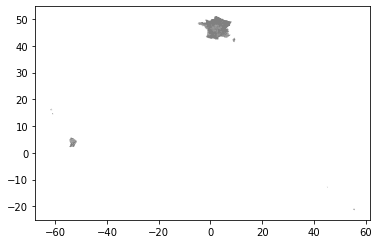

In [23]:
gdf_zones_communes.plot(facecolor='gray')

# Load results in BigQuery

In [143]:
from google.cloud import bigquery

In [144]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: test-rstudio-gcp


In [145]:
# connect to existing dataset

# Define a name for the dataset.
dataset_id = 'opengeokpi'

# The project defaults to the Client's project if not specified.
dataset = client.get_dataset(dataset_id)  # API request# create new dataset

# Define a name for the new dataset.
dataset_id = 'opengeokpi'

# The project defaults to the Client's project if not specified.
dataset = client.get_dataset(dataset_id)  # API request

In [146]:
# convert region geometry column to string
gdf_zones_regions['str_geom_regions'] = gdf_zones_regions.geometry.apply(lambda x: wkt.dumps(x))
gdf_zones_departements['str_geom_departements'] = gdf_zones_departements.geometry.apply(lambda x: wkt.dumps(x))
gdf_zones_communes['str_geom_communes'] = gdf_zones_communes.geometry.apply(lambda x: wkt.dumps(x))

In [147]:
gdf_zones_regions.head()

,geometry,regions_level,regions_code,regions_name,regions_population,regions_area,str_geom_regions
51287,"MULTIPOLYGON (((-61.61404 16.29611, -61.61550 ...",fr:region,01,Guadeloupe,397990.0,1628.0,MULTIPOLYGON (((-61.6140430000000023 16.296105...
51288,"MULTIPOLYGON (((-61.00189 14.56262, -61.00297 ...",fr:region,02,Martinique,380877.0,1128.0,MULTIPOLYGON (((-61.0018859999999989 14.562618...
51289,"MULTIPOLYGON (((-53.16965 5.52098, -53.15026 5...",fr:region,03,Guyane,282731.0,83534.0,MULTIPOLYGON (((-53.1696450000000027 5.5209840...
51290,"MULTIPOLYGON (((55.80443 -21.25182, 55.80204 -...",fr:region,04,La Réunion,866506.0,2512.0,MULTIPOLYGON (((55.8044330000000031 -21.251815...
51291,"MULTIPOLYGON (((45.12651 -12.93367, 45.13097 -...",fr:region,06,Mayotte,226915.0,376.0,MULTIPOLYGON (((45.1265140000000002 -12.933668...


In [148]:
# drop geometry column
zones_regions_df = gdf_zones_regions.drop(columns=['geometry'])
zones_departements_df = gdf_zones_departements.drop(columns=['geometry'])
zones_communes_df = gdf_zones_communes.drop(columns=['geometry'])

## Load zones_regions_geo

In [149]:
# load zones_regions_df in bigquery
table_ref = dataset.table("zones_regions_df")
job = client.load_table_from_dataframe(zones_regions_df, table_ref, location="US")

job.result()  # Waits for table load to complete.
print("Loaded dataframe to {}".format(table_ref.path))

Loaded dataframe to /projects/test-rstudio-gcp/datasets/opengeokpi/tables/zones_regions_df


In [150]:
# create zones_regions_geo in bigquery
sql = """
    SELECT
  ST_GEOGFROMTEXT(str_geom_regions) AS geom_region,
  regions_level,
  regions_code,
  regions_name,
  regions_population,
  regions_area
FROM
  `test-rstudio-gcp.opengeokpi.zones_regions_df` ;
"""
table_ref = dataset.table("zones_regions_geo")
job_config = bigquery.QueryJobConfig(
    destination=table_ref
)


# Start the query, passing in the extra configuration.
query_job = client.query(sql, location="US", job_config=job_config)

query_job.result()  # Waits for the query to finish
print("Query results loaded to table {}".format(table_ref.path))

Query results loaded to table /projects/test-rstudio-gcp/datasets/opengeokpi/tables/zones_regions_geo


## Load zones_departements_geo

In [151]:
# load zones_departements_df in bigquery
table_ref = dataset.table("zones_departements_df")
job = client.load_table_from_dataframe(zones_departements_df, table_ref, location="US")

job.result()  # Waits for table load to complete.
print("Loaded dataframe to {}".format(table_ref.path))

Loaded dataframe to /projects/test-rstudio-gcp/datasets/opengeokpi/tables/zones_departements_df


In [152]:
# create zones_departements_geo in bigquery
sql = """
    SELECT
  ST_GEOGFROMTEXT(str_geom_departements) AS geom_departements,
  departements_level,
  departements_code,
  departements_name,
  departements_population,
  departements_area
FROM
  `test-rstudio-gcp.opengeokpi.zones_departements_df` ;
"""
table_ref = dataset.table("zones_departements_geo")
job_config = bigquery.QueryJobConfig(
    destination=table_ref
)


# Start the query, passing in the extra configuration.
query_job = client.query(sql, location="US", job_config=job_config)

query_job.result()  # Waits for the query to finish
print("Query results loaded to table {}".format(table_ref.path))

Query results loaded to table /projects/test-rstudio-gcp/datasets/opengeokpi/tables/zones_departements_geo


## Load zones_communes_geo

In [153]:
# load zones_departements_df in bigquery
table_ref = dataset.table("zones_communes_df")
job = client.load_table_from_dataframe(zones_communes_df, table_ref, location="US")

job.result()  # Waits for table load to complete.
print("Loaded dataframe to {}".format(table_ref.path))

Loaded dataframe to /projects/test-rstudio-gcp/datasets/opengeokpi/tables/zones_communes_df


In [154]:
# create zones_communes_geo in bigquery
sql = """
    SELECT
  ST_GEOGFROMTEXT(str_geom_communes) AS geom_communes,
  communes_level,
  communes_code,
  communes_name,
  communes_population,
  communes_area
FROM
  `test-rstudio-gcp.opengeokpi.zones_communes_df` ;
"""
table_ref = dataset.table("zones_communes_geo")
job_config = bigquery.QueryJobConfig(
    destination=table_ref
)


# Start the query, passing in the extra configuration.
query_job = client.query(sql, location="US", job_config=job_config)

query_job.result()  # Waits for the query to finish
print("Query results loaded to table {}".format(table_ref.path))

Query results loaded to table /projects/test-rstudio-gcp/datasets/opengeokpi/tables/zones_communes_geo
